<a href="https://www.kaggle.com/code/pawankumargunjan/mnist-handwritten-digit-classification?scriptVersionId=111954722" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h3 style="color:orange">Load Necessary Library</h3>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.metrics import classification_report

# setting a random seed to reproduce results
seed=4
tf.random.set_seed(4)

## Data Collection

### Load the mnist datasets

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = np.concatenate((X_train, X_test))
y_train = np.concatenate((Y_train, Y_test))
y_train = y_train.astype(int)

X_train.shape, y_train.shape

11501568/11490434 [==============================] - 1s 0us/step


((70000, 28, 28), (70000,))

### Read the given kaggle datasets

In [3]:
valid = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
valid.shape, test.shape

((42000, 785), (28000, 784))

## Data Preprocessing

In [4]:
y_validation = valid.label.values
x_validation = valid.drop('label', axis = 1).values

### Reshape the features to 28 X 28 shape

In [5]:
x_train = X_train.reshape(X_train.shape[0], 28,28)
x_validation = x_validation.reshape(x_validation.shape[0],28,28)
x_test = test.values.reshape(test.shape[0], 28,28)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape,  x_test.shape

((70000, 28, 28), (70000,), (42000, 28, 28), (42000,), (28000, 28, 28))

### Plot the first 50 digit with their actual label

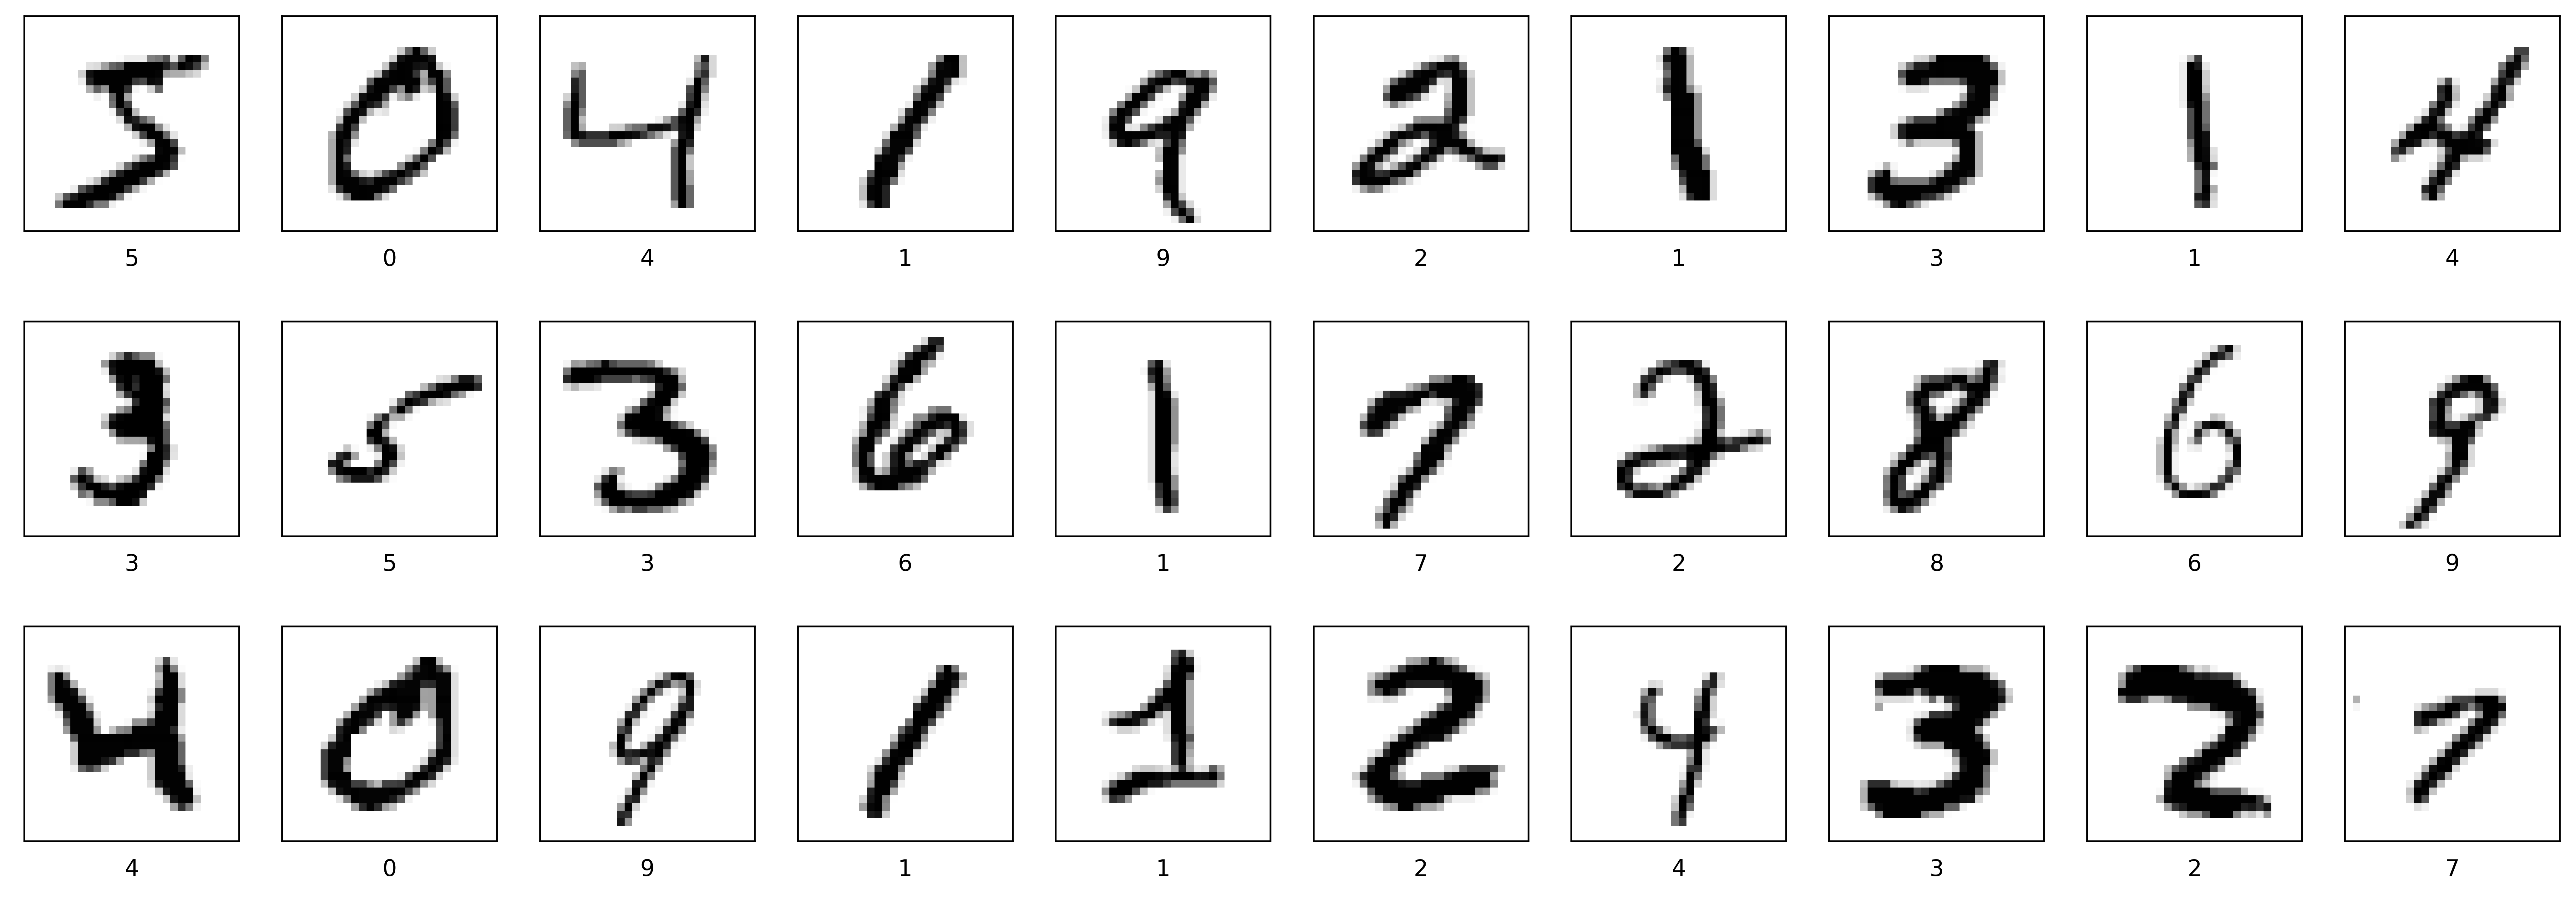

In [6]:
plt.figure(figsize=(20,7), dpi = 523)
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])                   # Adding label as the value of handwritten digit
plt.show()

#### Add a channels dimension

In [7]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_validation.reshape(-1,28,28,1)
x_test  = x_test.reshape(-1,28,28,1)

print('Train Data shape      :',x_train.shape)
print('Validation Data shape :',x_valid.shape)
print('Test Data shape       :',x_test.shape) 

Train Data shape      : (70000, 28, 28, 1)
Validation Data shape : (42000, 28, 28, 1)
Test Data shape       : (28000, 28, 28, 1)


#### Scalling the value for better accuracy

In [8]:
x_train, x_valid, x_test = x_train / 255, x_valid / 255, x_test / 255

In [9]:
# One hot-encoding the labels
y_train_ = tf.keras.utils.to_categorical(y_train)
y_valid_ = tf.keras.utils.to_categorical(y_validation)

## Model Building

#### Defining batch size, number epochs (iterations) and the steps in each epoch

In [10]:
# defining batch size, number epochs (iterations) and the steps in each epoch

batch = 70
epochs = 25

steps_per_epoch = x_train.shape[0]//batch
steps_per_epoch

1000

### Data augmentation

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                             zoom_range=0.15
                            )

# setting data generator to be ready for model

image_generator = datagen.flow(x_train, y_train_, 
                               batch_size=batch, 
                               seed=seed,
                              )

In [12]:
print('The Unique digits are :', sorted(pd.unique(y_train)))
n = len(pd.unique(y_train))
print('There are total',n, 'unique digits')

The Unique digits are : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
There are total 10 unique digits


### Model

In [13]:
# Model Bulding
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape = (28,28,1)),         # Convolution Layer
    layers.Conv2D(32, (4, 4), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),         # Convolution Layer
    layers.Conv2D(64, (4, 4), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),                                             # MaxPooling
    
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),                        
    layers.Dense(150, activation = tf.nn.relu),     # Hidden layer
    layers.Dense(150, activation = tf.nn.relu),      # Hidden layer
    layers.Dense(n, activation = tf.nn.softmax)     # Output layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          2

2022-11-24 12:42:11.796391: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


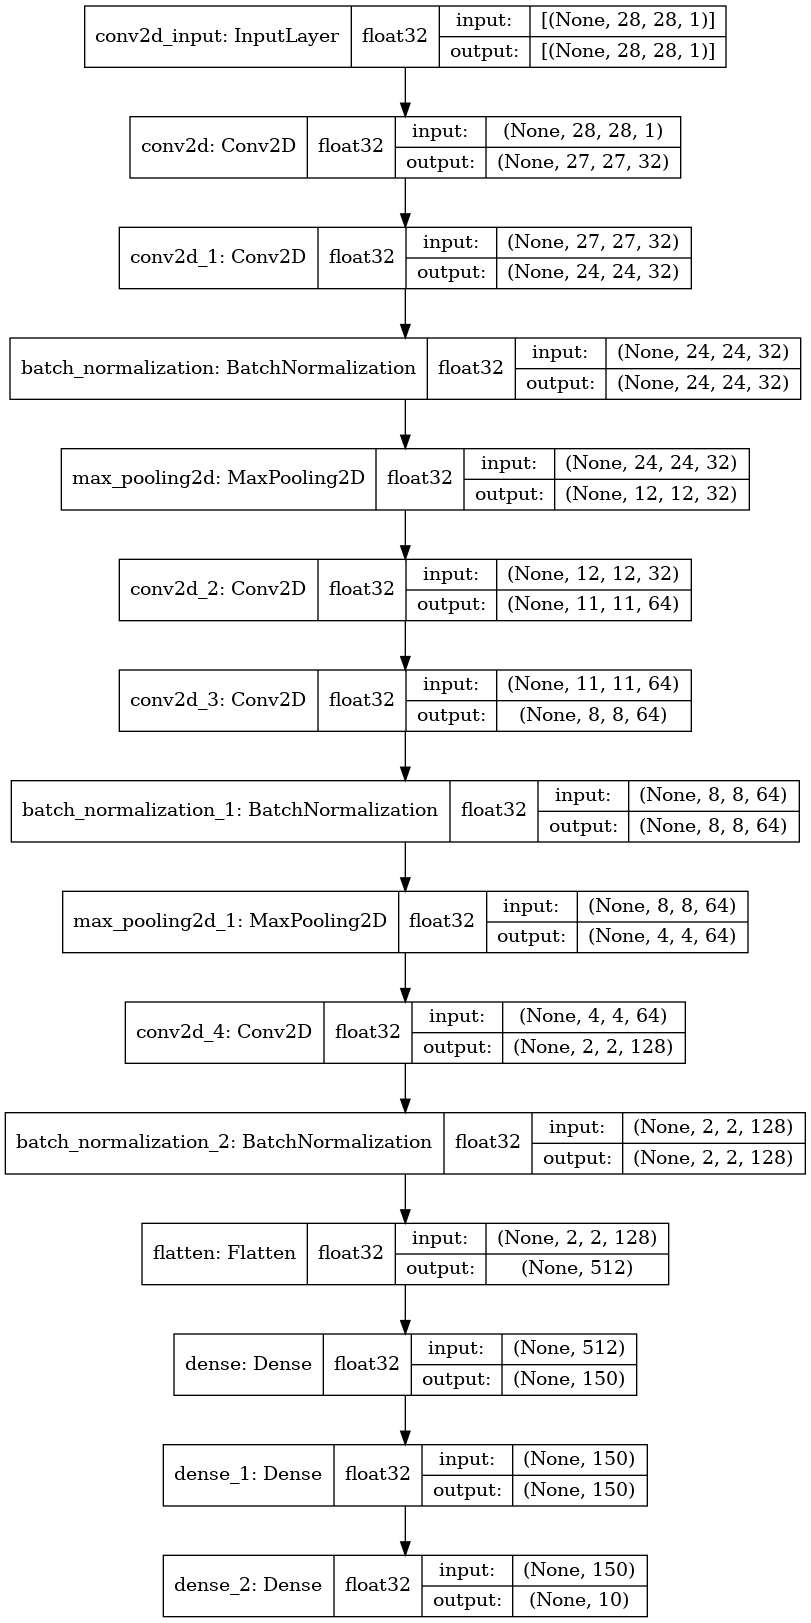

In [14]:
# Model Visualised
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True)

#### Additional parameters to control the training process, avoid overfitting, saving the best model in training, custamize the learning rate etc.

In [15]:
lr_rate = 0.0003

#Stop training when a monitored metric has stopped improving.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3,
                                                  min_delta = 1e-4,
                                                  restore_best_weights = True)
# save the Keras model or model weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'saved_model/best_model_todate', 
                                                 save_best_only = True, 
                                                 save_weights_only = True,
                                                 monitor='val_accuracy',
                                                 mode='max')

# terminates training when a NaN loss is encountered
tn = tf.keras.callbacks.TerminateOnNaN()

'''
A LearningRateSchedule that uses an exponential decay schedule.

When training a model, it is often useful to lower the learning rate as
the training progresses. This schedule applies an exponential decay function
to an optimizer step, given a provided initial learning rate.
'''
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = lr_rate,
                                                           decay_steps = steps_per_epoch//4,
                                                           decay_rate= 0.80,
                                                           staircase=True)
# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Reduce learning rate when a metric has stopped improving
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  factor = 0.1,
                                                  patience = 4, 
                                                  verbose = 3)

#### Choose an optimizer and loss function for training

In [16]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate) 

#### Compile the model

In [17]:
model.compile(optimizer=optimizer,loss=loss_object, metrics=['accuracy'])

#### Train the model

In [18]:
history = model.fit(image_generator, 
                    epochs=epochs, 
                    validation_data=(x_valid, y_valid_), 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [lr_scheduler, lr_plateau, checkpoint_callback, early_stopping, tn]
                   )

2022-11-24 12:42:13.990427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
1000/1000 [==============================] - 123s 122ms/step - loss: 0.1242 - accuracy: 0.9627 - val_loss: 0.0554 - val_accuracy: 0.9817
Epoch 2/25
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0333 - val_accuracy: 0.9893
Epoch 3/25
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 4/25
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.0407 - val_accuracy: 0.9877
Epoch 5/25
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.0189 - val_accuracy: 0.9937
Epoch 6/25
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.0164 - val_accuracy: 0.9945
Epoch 7/25
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0193 - accuracy: 0.9937 - val_

## Model Evaluation

In [19]:
loss, accuracy = model.evaluate(x_valid, y_valid_)
print('The accuracy of model on unknown data is',round((accuracy*100),2),'%')

1313/1313 [==============================] - 23s 17ms/step - loss: 0.0076 - accuracy: 0.9976
The accuracy of model on unknown data is 99.76 %


In [20]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']                        # Accuracy obtained on training data
val_acc = history_dict['val_accuracy']                # Accuracy obtained on Validation data

loss = history_dict['loss']                                  # Losses obtained on training data
val_loss = history_dict['val_loss']                          # Losses obtained on validation data

#### Training and validation loss

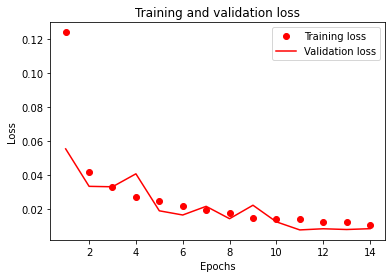

In [21]:
epochs = range(1, len(acc) + 1)                              # Epoch = range(1, 10+1)  10 iterations        

# Training Loss
plt.plot(epochs, loss, 'ro', label='Training loss')          # "ro" is for "red dot"
# Validation Loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')     # r is for "solid red line"

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Training and validation accuracy

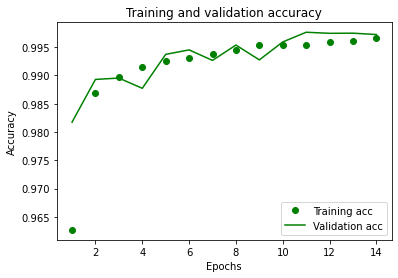

In [22]:
# Training accuracy
plt.plot(epochs, acc, 'go', label='Training acc')                 # "go" is for "green dot"
# Validation accuracy
plt.plot(epochs, val_acc, 'g', label='Validation acc')            # g is for "solid green line"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Predict the Label


In [23]:
# Predict the label
y_predicted = model.predict(x_valid)

# Get the maximum value integer as the output for the predicted value 
y_predicted_labels = [np.argmax(i) for i in y_predicted]

print('Predicted Label :',y_predicted_labels[:10])
print('Actual Label    :',y_validation[:10])

Predicted Label : [1, 0, 1, 4, 0, 0, 7, 3, 5, 3]
Actual Label    : [1 0 1 4 0 0 7 3 5 3]


### Confusion matrix

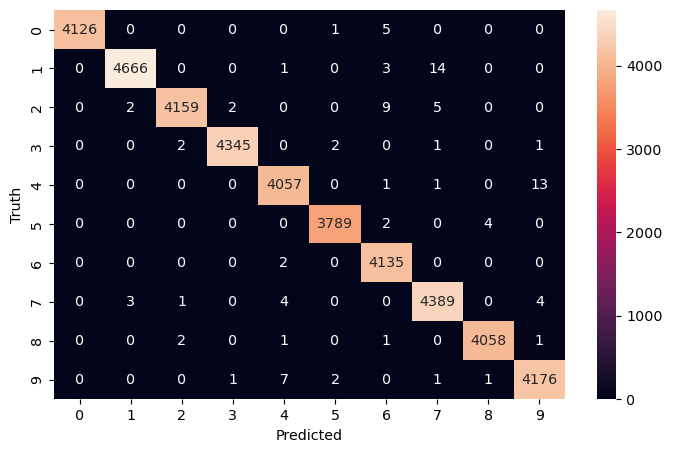

In [24]:
cm = tf.math.confusion_matrix(labels = y_validation, predictions=y_predicted_labels)

plt.figure(figsize = (8,5), dpi = 103)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Classification Report

In [25]:
print("Classification Report: \n", classification_report(y_validation, y_predicted_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       1.00      1.00      1.00      4684
           2       1.00      1.00      1.00      4177
           3       1.00      1.00      1.00      4351
           4       1.00      1.00      1.00      4072
           5       1.00      1.00      1.00      3795
           6       0.99      1.00      1.00      4137
           7       1.00      1.00      1.00      4401
           8       1.00      1.00      1.00      4063
           9       1.00      1.00      1.00      4188

    accuracy                           1.00     42000
   macro avg       1.00      1.00      1.00     42000
weighted avg       1.00      1.00      1.00     42000



### Verify predictions

In [26]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("Pred: {} ({:2.0f}%) \n Truth : {}".format(predicted_label, (100*np.max(predictions_array)),
                                                          true_label), color=color)
    
def plot_value_array(i, predictions_array, true_labels):
    true_label = true_labels[i]
    plt.grid(False)
    plt.xticks(range(10))

    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

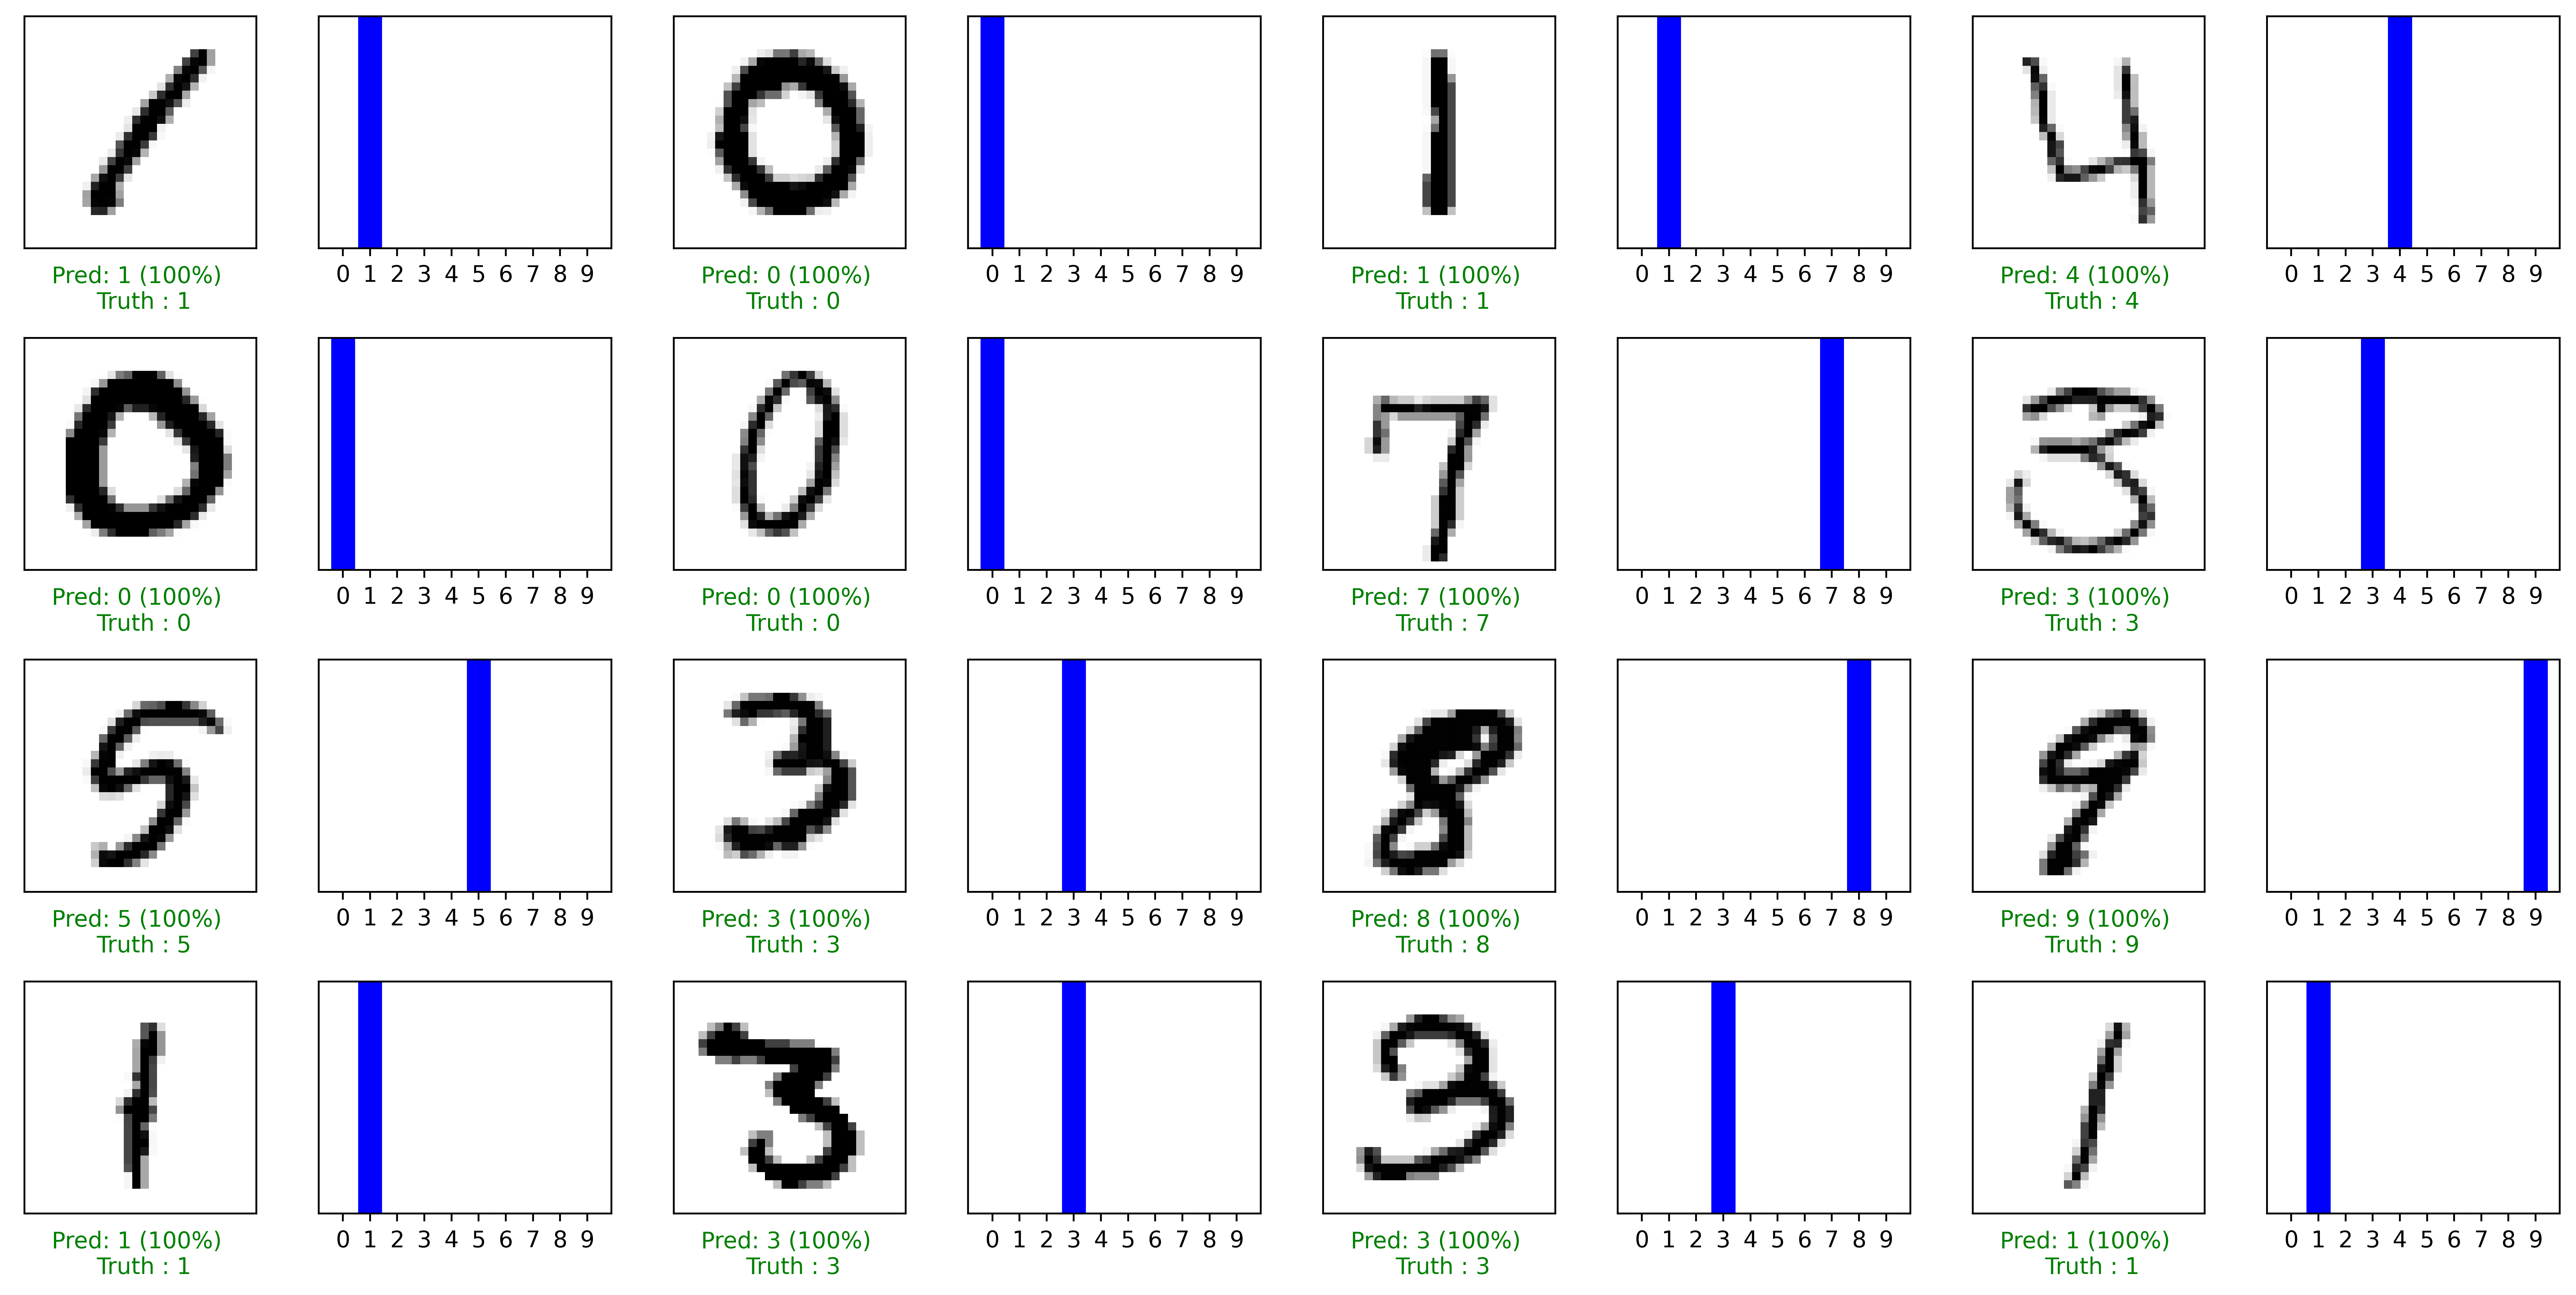

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows), dpi = 523)
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_predicted[i], y_validation, x_valid)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_predicted[i], y_validation)
plt.tight_layout()
plt.show()

### Check the wrong predictions

In [28]:
#predicted_label = np.argmax(predictions_array)
count = 0
wrong_predictions = []
for i in range(len(y_validation)):
    predicted_label = np.argmax(y_predicted[i])
    if predicted_label != y_validation[i]:
        count +=1
        wrong_predictions.append(i)
print('There are',count,'wrong predictions in test datasets')
print('Wrong predicted indices :\n',wrong_predictions)

There are 100 wrong predictions in test datasets
Wrong predicted indices :
 [191, 445, 639, 1107, 1968, 2316, 3232, 3565, 3997, 4072, 4115, 4226, 4790, 4954, 5390, 5695, 5859, 5885, 6112, 6268, 7024, 7389, 7527, 7547, 8194, 10026, 11406, 11750, 12308, 12532, 12962, 13477, 13677, 13791, 14362, 15081, 15219, 15653, 15679, 16301, 16598, 17004, 17412, 17972, 18989, 19390, 19811, 20003, 20542, 20891, 21115, 21423, 21911, 22199, 22214, 22554, 23299, 24210, 24477, 24544, 24611, 24729, 24891, 25073, 25378, 25708, 25946, 26251, 26358, 26785, 27364, 27826, 28095, 29296, 30317, 30706, 31954, 32367, 32466, 32654, 33107, 34078, 35094, 35338, 36018, 36520, 36793, 36916, 36984, 37013, 37719, 37786, 37887, 37952, 39960, 39990, 40062, 40114, 40208, 41369]


In [29]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows), dpi = 723)

for ix in range(num_images):
    i = wrong_predictions[ix]

    plt.subplot(num_rows, 2*num_cols, 2*ix+1)
    plot_image(i, y_predicted[i], y_validation, x_valid)
    plt.subplot(num_rows, 2*num_cols, 2*ix+2)
    plot_value_array(i, y_predicted[i], y_validation)
plt.tight_layout()
plt.show()

## Submission

In [30]:
predict = model.predict(x_test)
labels = [np.argmax(i) for i in predict]

labels[:5]

[2, 0, 9, 0, 3]

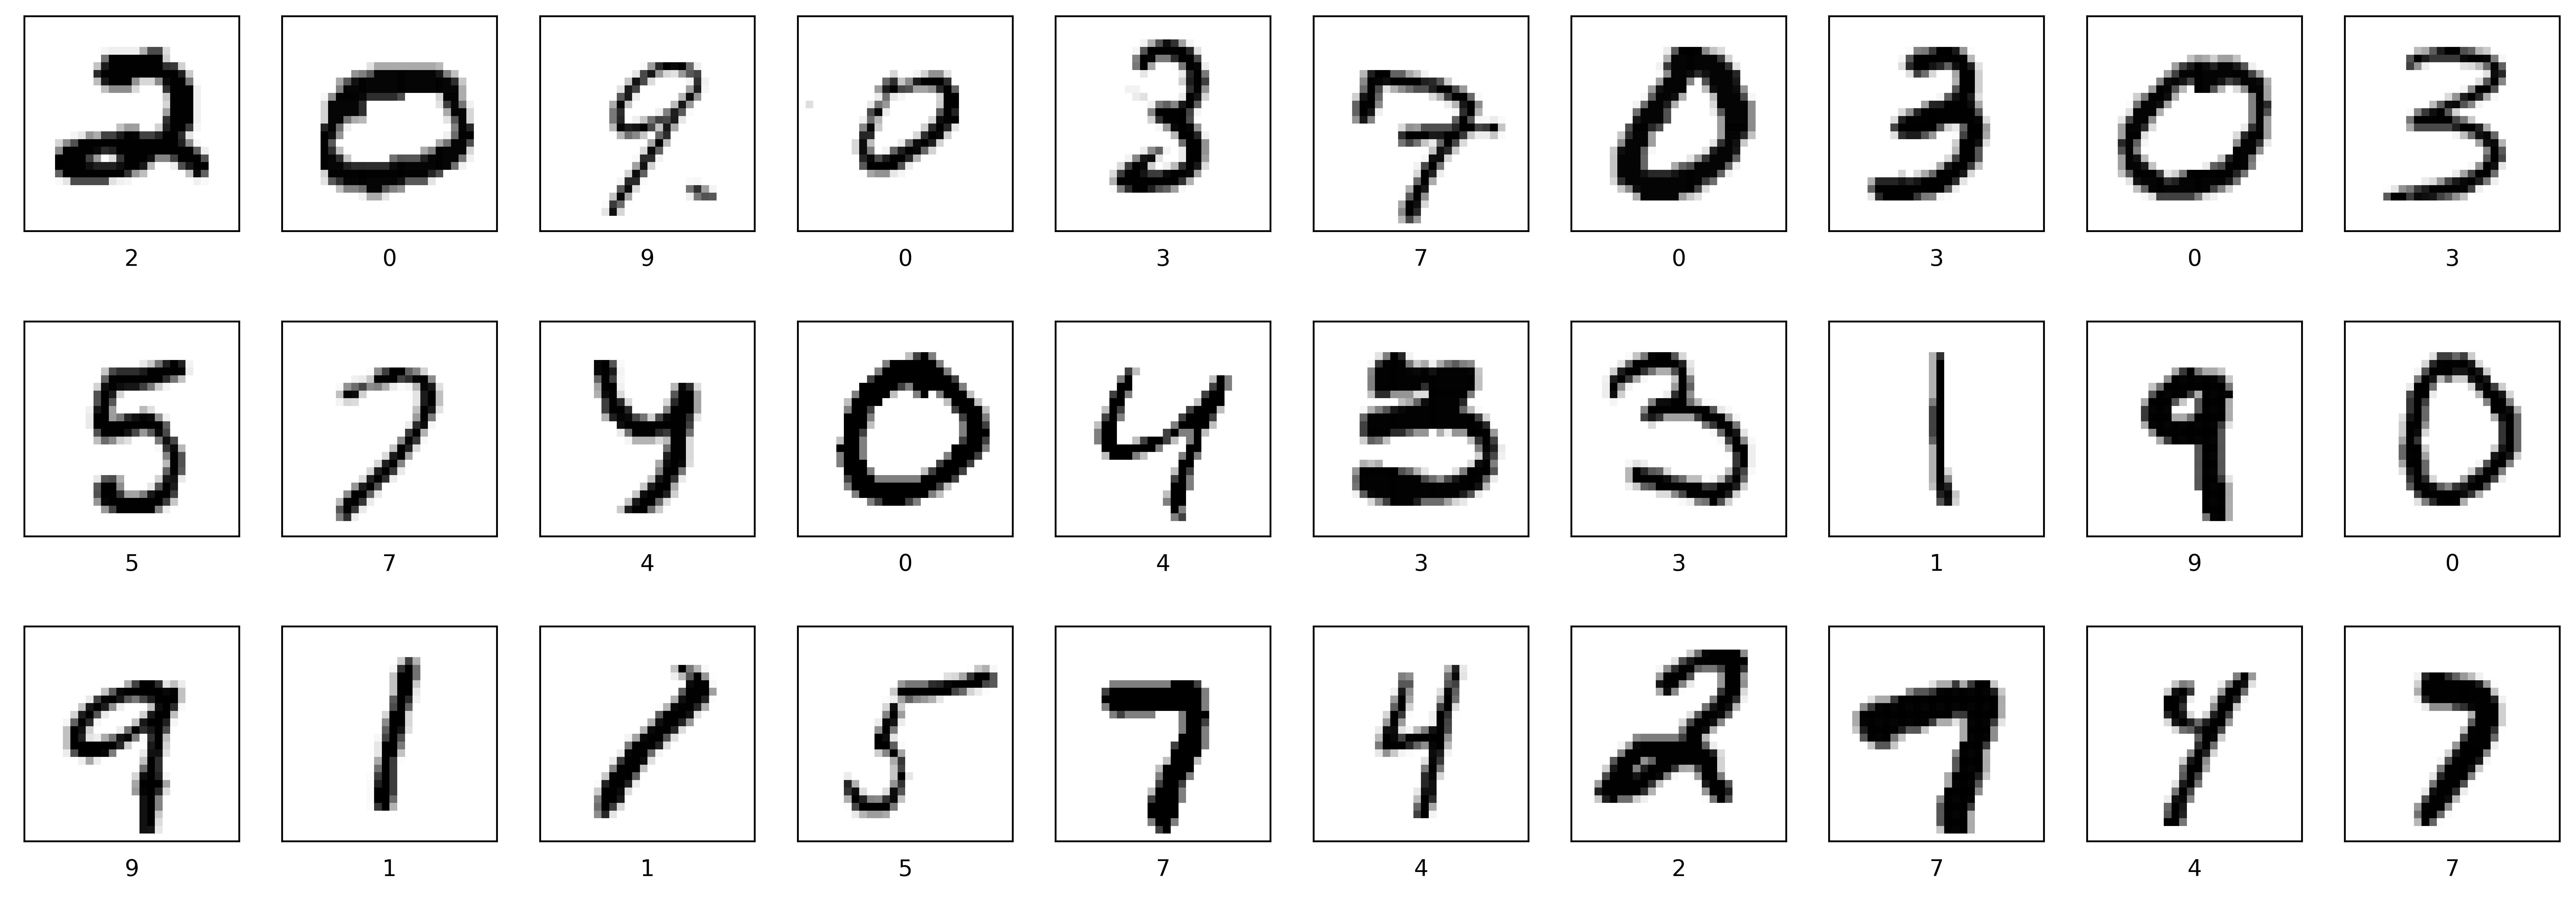

In [31]:
plt.figure(figsize=(20,7), dpi = 523)
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])                   # Adding label as the value of handwritten digit
plt.show()

### Submission

In [32]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label']=labels
submission.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
